In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import lfilter
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import logistic, circmean, vonmises, circstd 
import random
import time
import os

In [3]:
def connectivity(n, modes):
    """Creates a (``n`` x ``n``) connectivity matrix for the ring neural field model.

    :param int n: number of rate neurons/population.
    :param collections.Iterable[float] modes: amplitude of the modes of connectivity ordered from 0 to n_modes.
    :return: connectivity matrix.
    :rtype: np.ndarray
    """
    
    [i_n, j_n] = np.meshgrid(range(n), range(n))
    ij = (i_n - j_n) * (2.0 * np.pi / n)

    jphi = 0
    for k, mode in enumerate(modes):
        if k == 0:
            jphi = mode
        else:
            jphi += 2.0 * mode * np.cos(k * ij)

    return jphi 

In [4]:
# Transfer function (scalar)

def sigmoid_pw(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, scalar version.

    :param float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: float
    """
    
    if isinstance(x, (list, np.ndarray)):
        return sigmoid_pw_v(x, a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    if x <= 0.0:
        return a * gamma / tau
    elif 0.0 < x < 1.0:
        return (a + x ** 2.0) * gamma / tau
    else:
        return (a + 2.0 * np.sqrt(x - 3.0 / 4.0)) * gamma / tau

In [5]:
# Transfer function (vectorial)

def sigmoid_pw_v(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, vectorial version.
    
    :param np.ndarray of float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: np.ndarray of float
    """
    
    if not isinstance(x, (list, np.ndarray)):
        return sigmoid_pw(float(x), a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    phi = x * 1.0
    # Conditions:
    m1 = (x <= 0.0)
    m3 = (x >= 1.0)
    m2 = ~(m1 | m3)
    # Function
    phi[m1] = a
    phi[m2] = a + x[m2] ** 2
    phi[m3] = a + 2.0 * np.sqrt(x[m3] - 3.0 / 4.0)

    return phi * gamma / tau 

In [6]:
def ou_process(dt, nsteps, mu, sigma, tau, trials=1, n_spatial=1, seed=None):
    """ Generates an approximation of a single (or trials) Ornstein-Uhlenbeck process(es)
        for a single (oumodes) units.

    :param float dt: integration time-step.
    :param int nsteps: number of time steps.
    :param float mu: offset of the processs.
    :param float sigma: standard deviation of the process.
    :param float tau: time scale of the process (< dt).
    :param int trials: number of processes to be generated (trials).
    :param int n_spatial: number of spatially distributed units or modes of Fourier.
    :param int or None seed: seed for the random number generator.
    :return: time series: array (nsteps x trials x oumodes).
    :rtype: np.ndarray
    """
    
    # Constants
    a = np.exp(-dt / tau)
    b = mu * (1.0 - a)
    c = sigma * np.sqrt(1.0 - a ** 2)

    if seed is not None:
        np.random.seed(seed)

    s = lfilter(np.ones(1), [1, -a], b + c * np.random.randn(nsteps, trials, n_spatial), axis=0)
    
    return s

In [7]:
def compute_phase(x, n, c=(0.0,), s=(0.0,), wavenumber=1):
    """ Function that gives an approximate value of the phase of a spatial profile by projecting the vector x
    into a cosine function.

    :param Cython.Includes.numpy.ndarray x: firing rates matrix (or vector) with shape (d1, d2, ..., n).
    :param int n: spatial dimension (spatial discretization).
    :param np.ndarray of float c: cosine function, precompute it for faster computation.
    :param np.ndarray of float s: sine function, precompute it for faster computation.
    :param int wavenumber: wavenumber of the corresponding phase that we want to compute.
    :rtype: np.ndarray of float
    """

    # Check external cosine and sine functions
    if len(c) != n or len(s) != n:
        c = np.cos(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)
        s = np.sin(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)

    # norm of sine and cosine functions depends on n (discretization of the space)
    return np.arctan2((np.dot(x, s) / (n / 2.0) ** 2), (np.dot(x, c) / (n / 2.0) ** 2))

In [8]:
def equalbins(x, nbins):
    """ Computes the binning vector of a given data vector `x` categorized in equal proportion in `nbins`.

    :param np.ndarray x: vector of data to be binned.
    :param int nbins: number of bins.
    :return: a vector with the bins corresponding to each data point.
    :rtype: np.ndarray
    """
    
    quantiles = np.quantile(x, np.arange(1, nbins) / nbins)
    edges = np.concatenate(([-np.inf], quantiles, [np.inf]))
    
    return np.digitize(x, edges)

In [9]:
def compute_estimation(dataframe, nbins=41, xlabel='theta', ylabel='theta_est', **kwargs):
    """ Computes the estimation curve given an angular binning with `nbins` bins.
    
    :param pd.DataFrame dataframe: data-frame containing the circular mean of the stimulus orientation along with
                                   its estimation by the model.
    :param int nbins: number of bins to divide the angular range and perform the average across trials.
    :param str ylabel: label of the outcome column in the data-frame.
    :param kwargs: additional keyword arguments.
    :return: Returns a tuple (binning: average stimulus orientation, average estimation, standard error).
    :rtype: (pd.Series, pd.Series, pd.Series)
    """
    
    lim = kwargs.pop('lim', np.pi/2)
    # We define the categories for the data points and the model points/line
    dataframe['bin'] = equalbins(dataframe[xlabel], nbins)
    # Group the data by the binning and compute the circular mean of the stimulus orientation averages and the 
    # circular mean of the estimated average orientations
    gby_bin = dataframe.groupby('bin')
    x_avg = gby_bin[xlabel].apply(circmean, low=-np.pi, high=np.pi)
    y_avg = gby_bin[ylabel].apply(circmean, low=-np.pi, high=np.pi)
    y_std = gby_bin[ylabel].apply(circstd, low=-np.pi, high=np.pi)
    # Select the data inside the desired range
    s_x = x_avg.loc[np.abs(x_avg) <= lim]
    s_y = y_avg.loc[np.abs(x_avg) <= lim]
    s_e = y_std.loc[np.abs(x_avg) <= lim]
    return s_x, s_y, s_e

### Single trial

In [149]:
start = time.time()
# Define some variables

tstim = 3.500
nstim = 4
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring network
ntrials = 1

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)

r = np.ones((rsteps, n)) * 0.1
phase = np.zeros(rsteps)

exc_drive = 0.05
i0 = 1 + exc_drive # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
i1 = 5E-3
i2 = 25E-3

theta_stim = np.array([30, 10, -5, 20]) * np.pi / 180 # angular direction of the stimulus (set of 8 Gabor patches)
gabor_patch = i1 * np.cos(1 * (np.repeat(theta[np.newaxis,:], nstim, axis=0) - theta_stim[:, np.newaxis]))

modes = [-2.0, 1.0, .5, .5, .5, .5, .5]
cnt = connectivity(n, modes)
dec_mode = 1

mu, sigmaou, tau_ou = 0, 0.10, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n), seed=None

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < tmax:    
    i_stim = gabor_patch[np.floor(temps / (tmax / nstim)).astype(int)]

    # Time step variables
    kp = tstep % rsteps #kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps #k is the -1 step

    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    #3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
        phase[kp] = compute_phase(r[kp], n)
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0
    
    tstep += 1
    temps = tstep * dt

if dec_mode == 1:    

    # Reset some variables
    tbias = 1.500
    tpoints_bias = np.arange(0, tbias, dt)
    rsteps_bias = len(tpoints_bias)

    r = np.concatenate((r, np.ones((rsteps_bias, n)) * 0.1))
    phase = np.concatenate((phase, np.zeros(rsteps_bias)))

    tstep = 0    
    temps = 0.0

    i_stim = i2 * np.cos(180/30 * (theta - np.pi/180 * 30))
    ou = ou_process(dt, rsteps_bias, mu, sigmaou, tau_ou, ntrials, n) # (stim_steps, ntrials, n) seed=None

    while temps < tbias:
            
        # Time step variables
        kp = tstep % rsteps_bias + rsteps #kp is the 0 step
        k = (tstep + rsteps_bias - 1) % (rsteps_bias - 1) + (rsteps - 1) #k is the -1 step

        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)

        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp - rsteps], tau=tau)) 
            phase[kp] = compute_phase(r[kp], n)
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0

        tstep += 1
        temps = tstep * dt

end = time.time()
print("Real stimulus direction:", theta_stim * 180 / np.pi % 360)
print("Phase of the bump:", phase * 180 / np.pi % 360)
print("Time elapsed:", end - start)

Real stimulus direction: [ 30.  10. 355.  20.]
Phase of the bump: [15.39138462 18.88823807  0.70199971 ... 25.73452556 25.72567362
 16.1773157 ]
Time elapsed: 11.149544954299927


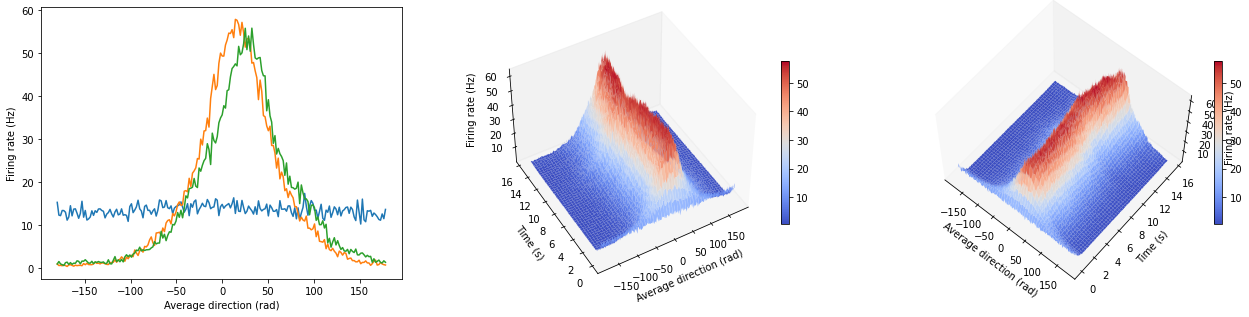

In [150]:
fig = plt.figure(figsize=(22, 5))
fig.tight_layout(pad=3.0)

ax1 = fig.add_subplot(131)
for i in [150, rsteps, -2]:
    ax1.plot(theta * 180/np.pi, r[i])
ax1.set_xlabel('Average direction (rad)')
ax1.set_ylabel('Firing rate (Hz)')

x = theta * 180 / np.pi
y = np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[50:-1]
X,Y = np.meshgrid(x,y)
Z = r[50:-1]

ax2 = fig.add_subplot(132, projection='3d')
surf1 = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax2.plot

ax2.view_init(45, 240)
ax2.set_xlabel('Average direction (rad)')
ax2.set_ylabel('Time (s)')
ax2.zaxis.set_label_coords(40, -10)
ax2.zaxis.set_rotate_label(False) 
ax2.set_zlabel('Firing rate (Hz)', rotation=90)
ax2.grid(False)

fig.colorbar(surf1, ax=ax2, shrink=0.6, aspect=20)

ax3 = fig.add_subplot(133, projection='3d')
surf1 = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax3.plot

ax3.view_init(60, 310)
ax3.set_xlabel('Average direction (rad)')
ax3.set_ylabel('Time (s)')
ax3.zaxis.set_label_coords(40, -10)
ax3.zaxis.set_rotate_label(False) 
ax3.set_zlabel('Firing rate (Hz)', rotation=90)
ax3.grid(False)

fig.colorbar(surf1, ax=ax3, shrink=0.6, aspect=20)

plt.show() 

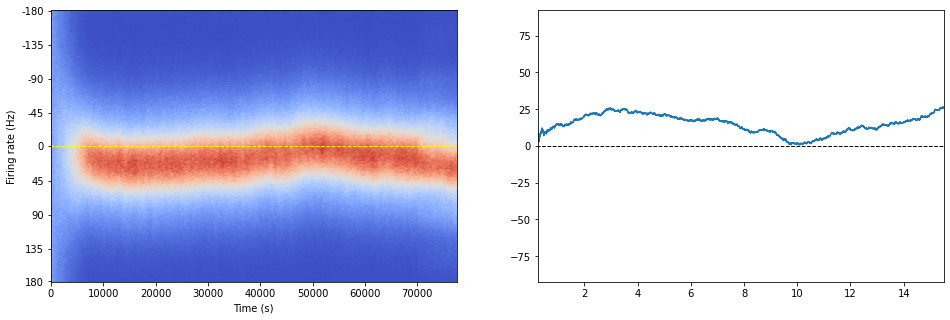

In [151]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(121)
x = np.arange(r[100:-1].shape[0])
y = np.ones(np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[100:-1].shape) * 100
ax1.imshow(r.T, aspect='auto', cmap=cm.coolwarm)
ax1.plot(x, y, '--', lw=1, color='yellow')
ax1.set_yticks([0, 25, 50, 75, 99.5, 125, 150, 175, 199]) # choose which x locations to have ticks
ax1.set_yticklabels([-180, -135, -90, -45, 0, 45, 90, 135, 180]) # set the labels to display at those ticks
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing rate (Hz)')

ax2 = fig.add_subplot(122)
ax2.plot(np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[100:-1], phase[100:-1] * 180/np.pi)
ax2.axis([0.25, tmax + tbias , -92.5, 92.5])
x = np.linspace(0, tmax + tbias, 10)
y = np.repeat(0, x.shape)
ax2.plot(x, y, '--', lw=1, color='black')
plt.show()

### Stability plots

In [204]:
start = time.time()
# Define some variables

tstim = 1.000
nstim = 3
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring network
ntrials = 19

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)

r = np.ones((rsteps, ntrials, n)) * 0.1
phase = np.zeros((rsteps, ntrials))

exc_drive = 0.05
i0 = 1 + exc_drive # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
i1 = 5E-3
i2 = 100E-3

modes = [-2.0, 1.0, .5, .5, .5, .5]
cnt = connectivity(n, modes)
dec_mode = 1

mu, sigmaou, tau_ou = 0, 0.10, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n), seed=None

#theta_stim = np.linspace(-90, 90, ntrials) * np.pi / 180 # angular direction of stimulus
#Theta, Theta_stim = np.meshgrid(theta, theta_stim)
#i_stim = i1 * np.cos(Theta - Theta_stim)
theta_stim = np.concatenate((np.random.uniform(-90 * np.pi / 180, 90 * np.pi / 180, (nstim, ntrials)).T, np.linspace(-90, 90, 19)[:,np.newaxis] * np.pi / 180), axis=1)
gabor_patch = i1 * np.cos(1 * (np.repeat(np.repeat(theta[np.newaxis,np.newaxis,:], nstim+1, axis=0), ntrials, axis=1) - theta_stim.T[:,:,np.newaxis]))

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < tmax:
    i_stim = gabor_patch[np.floor(temps / (tmax / nstim)).astype(int)]
    
    # Time step variables
    kp = tstep % rsteps # kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps # k is the -1 step

    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    # 3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau))
        phase[kp] = compute_phase(r[kp], n)
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0

    tstep += 1
    temps = tstep * dt
                    
if dec_mode == 1:    
    mu, sigmaou, tau_ou = 0, 0.10, 1E-3
    
    # Reset some variables
    tbias = 3.50
    tpoints_bias = np.arange(0, tbias, dt)
    rsteps_bias = len(tpoints_bias)

    r = np.concatenate((r, np.ones((rsteps_bias, ntrials, n)) * 0.1), axis=0)
    phase = np.concatenate((phase, np.zeros((rsteps_bias, ntrials))), axis=0)

    tstep = 0    
    temps = 0.0

    i_stim = i2 * np.cos(180/30 * (theta - np.pi/180 * 30))
    ou = ou_process(dt, rsteps_bias, mu, sigmaou, tau_ou, ntrials, n) # (stim_steps, ntrials, n) seed=None

    while temps < tbias:
        #if temps >= tbias / 2: i_stim = 0

        # Time step variables
        kp = tstep % rsteps_bias + rsteps #kp is the 0 step
        k = (tstep + rsteps_bias) % rsteps_bias + (rsteps - 1) #k is the -1 step

        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)

        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp - rsteps], tau=tau)) 
            phase[kp] = compute_phase(r[kp], n)
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0

        tstep += 1
        temps = tstep * dt
    
end = time.time()
print("Time elapsed:", end - start)

Time elapsed: 19.505873203277588


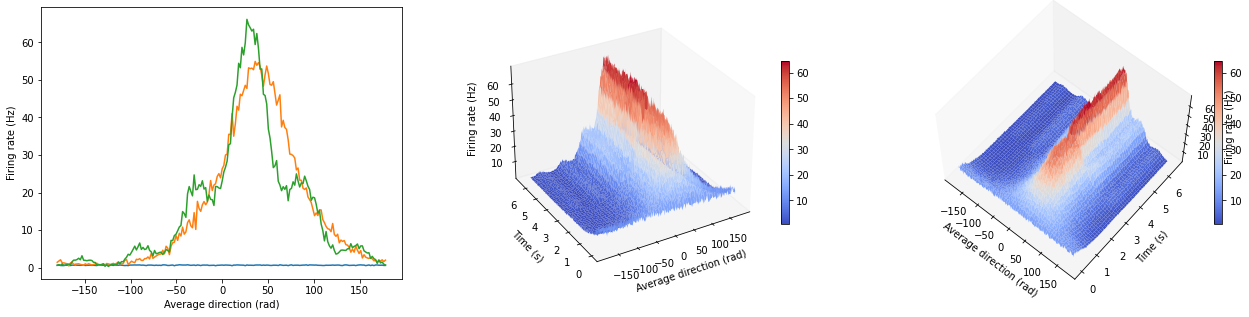

In [205]:
fig = plt.figure(figsize=(22, 5))
fig.tight_layout(pad=3.0)

trial = 3

ax1 = fig.add_subplot(131)
for i in [0, rsteps, -2]:
    ax1.plot(theta * 180/np.pi, r[i, trial])
ax1.set_xlabel('Average direction (rad)')
ax1.set_ylabel('Firing rate (Hz)')

x = theta * 180 / np.pi
y = np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[50:-1]
X,Y = np.meshgrid(x,y)
Z = r[50:-1, trial]

ax2 = fig.add_subplot(132, projection='3d')
surf1 = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax2.plot

ax2.view_init(30, 240)
ax2.set_xlabel('Average direction (rad)')
ax2.set_ylabel('Time (s)')
ax2.zaxis.set_label_coords(40, -10)
ax2.zaxis.set_rotate_label(False) 
ax2.set_zlabel('Firing rate (Hz)', rotation=90)
ax2.grid(False)

fig.colorbar(surf1, ax=ax2, shrink=0.6, aspect=20)

ax3 = fig.add_subplot(133, projection='3d')
surf1 = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax3.plot

ax3.view_init(60, 310)
ax3.set_xlabel('Average direction (rad)')
ax3.set_ylabel('Time (s)')
ax3.zaxis.set_label_coords(40, -10)
ax3.zaxis.set_rotate_label(False) 
ax3.set_zlabel('Firing rate (Hz)', rotation=90)
ax3.grid(False)

fig.colorbar(surf1, ax=ax3, shrink=0.6, aspect=20)

plt.show()

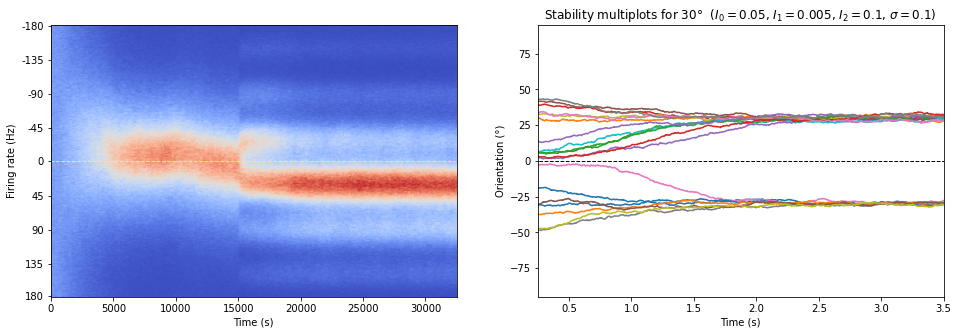

In [206]:
fig = plt.figure(figsize=(16, 5))

trial = 2
name = 'Stability multiplots for 30\N{DEGREE SIGN}' + '  ($I_0=$' + str(exc_drive) + ', $I_1=$'+ str(i1) + ', $I_2=$'+ str(i2) + ', $\sigma=$' + str(sigmaou) + ')'

ax1 = fig.add_subplot(121)
x = np.arange(r[100:-1, trial].shape[0])
y = np.ones(np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[100:-1].shape) * 100
ax1.imshow(r[:,trial].T, aspect='auto', cmap=cm.coolwarm)
ax1.plot(x, y, '--', lw=1, color='yellow')
ax1.set_yticks([0, 25, 50, 75, 99.5, 125, 150, 175, 199]) # choose which x locations to have ticks
ax1.set_yticklabels([-180, -135, -90, -45, 0, 45, 90, 135, 180]) # set the labels to display at those ticks
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing rate (Hz)')

ax2 = fig.add_subplot(122)
for i in range(ntrials):
    ax2.plot(np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[rsteps-1500:] - np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[rsteps-1500:rsteps-1499],
             phase[rsteps-1500:, i] * 180 / np.pi)
ax2.axis([0.25, tbias , -95, 95])
ax2.set_title(name)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Orientation (\N{DEGREE SIGN})')
x = np.linspace(0, tmax + tbias, 10)
y = np.repeat(0, x.shape)
ax2.plot(x, y, '--', lw=1, color='black')
plt.show()

### Arbitrary number of trials

In [807]:
df = pd.DataFrame(columns=['theta', 'theta_est'])

start = time.time()
# Define some variables

tstim = .750
nstim = 1
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring structure

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)
ntrials = 50

exc_drive = 0.005
i0 = 1 + exc_drive # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
i1 = 10E-3
i2 = 180E-3

modes = [-2.0, 1.0, .5, .5, .5, .5]
cnt = connectivity(n, modes)
dec_mode = 1

for i in range(100):
    r = np.ones((rsteps, ntrials, n)) * 0.1
    theta_stim = np.random.uniform(-30 * np.pi / 180, 30 * np.pi / 180, ntrials) # angular direction of stimulus
    Theta, Theta_stim = np.meshgrid(theta, theta_stim)
    i_stim = i1 * np.cos(Theta - Theta_stim)

    mu, sigmaou, tau_ou = 0.0, 0.00, 1E-3
    ou = ou_process(dt, rsteps, mu, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n) seed=None
    
    # Loop
    tstep = 0    
    temps = 0.0
    ttau = dt / tau

    while temps < tmax:
        # Time step variables
        kp = tstep % rsteps # kp is the 0 step
        k = (tstep + rsteps - 1) % rsteps # k is the -1 step
        
        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)
 
        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0
            
        tstep += 1
        temps = tstep * dt
                    
    if dec_mode == 1:
        mu, sigmaou, tau_ou = 0.0, 0.10, 1E-3
                
        # Reset some variables
        tbias = .500
        tpoints_bias = np.arange(0, tbias, dt)
        rsteps_bias = len(tpoints_bias)

        tstep = 0    
        temps = 0.0
            
        r = np.concatenate((r, np.ones((rsteps_bias, ntrials, n)) * 0.1), axis=0)

        i_stim = i2 * np.cos(180/30 * (theta - np.pi/180 * 30))
        #i_stim = i2 * (vonmises.pdf(theta - 45 * np.pi/180, kappa=150) + vonmises.pdf(theta + 45 * np.pi/180, kappa=150) - 
        #               vonmises.pdf(theta - 0.1, kappa=100) - vonmises.pdf(theta + 0.1, kappa=100)) / np.max(vonmises.pdf(theta, kappa=100))                                                                                
        
        ou = ou_process(dt, rsteps_bias, mu, sigmaou, tau_ou, ntrials, n) # (stim_steps, ntrials, n) seed=None
                                                                                                             
        while temps < tbias:
            # Time step variables
            kp = tstep % rsteps_bias + rsteps #kp is the 0 step
            k = (tstep + rsteps_bias - 1) % (rsteps_bias - 1) + (rsteps - 1) #k is the -1 step

            # 2. Presynaptic inputs
            s = 1.0 / n * np.dot(r[k], cnt)

            # 3. Integration
            try:
                r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp - rsteps], tau=tau)) 
            except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
                r[r < 1E-12] = 0.0
                
            tstep += 1
            temps = tstep * dt
    
    df = pd.concat([df, pd.DataFrame({'theta':theta_stim, 'theta_est': compute_phase(r[-2], n)})], axis=0, levels=None, ignore_index=True)
    if i % 5 == 0: print(i)
    
end = time.time()
print("Time elapsed:", end - start)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
Time elapsed: 478.5051519870758


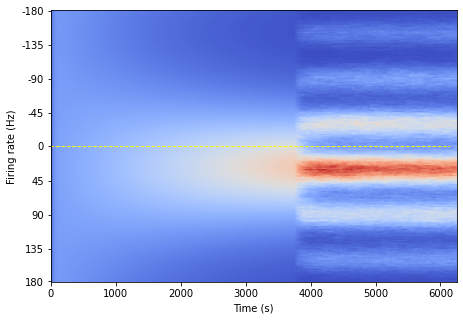

In [808]:
fig = plt.figure(figsize=(16, 5))

trial = 2

ax1 = fig.add_subplot(121)
x = np.arange(r[100:-1, trial].shape[0])
y = np.ones(np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[100:-1].shape) * 100
ax1.imshow(r[:,trial].T, aspect='auto', cmap=cm.coolwarm)
ax1.plot(x, y, '--', lw=1, color='yellow')
ax1.set_yticks([0, 25, 50, 75, 99.5, 125, 150, 175, 199]) # choose which x locations to have ticks
ax1.set_yticklabels([-180, -135, -90, -45, 0, 45, 90, 135, 180]) # set the labels to display at those ticks
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing rate (Hz)')
plt.show()

In [809]:
# Edit DataFrame 
conditions = [
    (df['theta_est'] >= 0),
    (df['theta_est'] < 0)]
values = ['CW', 'CCW']
df['choice'] = np.select(conditions, values)

conditions = [
    (df['choice'] == 'CW'),
    (df['choice'] == 'CCW')]
values = [1, 0]

df['binary'] = np.select(conditions, values)
df['bias'] = np.abs(df['theta_est'] - df['theta'])

sx, sy, ss = compute_estimation(df, nbins=41)
[sx, sy, ss] = [np.rad2deg(k) for k in [sx, sy, ss]]

df

,theta,theta_est,choice,binary,bias,bin
0,-0.221603,-0.343802,CCW,0,0.122199,12
1,-0.199562,-0.283114,CCW,0,0.083552,13
2,0.319161,0.430994,CW,1,0.111833,34
3,-0.388004,-0.537854,CCW,0,0.149850,6
4,-0.194875,-0.280876,CCW,0,0.086001,13
...,...,...,...,...,...,...
4995,0.184267,0.307017,CW,1,0.122750,28
4996,-0.358512,-0.483700,CCW,0,0.125188,7
4997,0.196421,0.227582,CW,1,0.031162,29
4998,0.172216,0.197389,CW,1,0.025173,28


In [810]:
# Group DataFrame by intervals of theta 
grouped = df.groupby(pd.cut(df.theta, np.append(theta, [np.pi])))

df2 = pd.DataFrame({
    'theta': theta, 
    'theta_est': grouped.theta_est.apply(circmean, low=-np.pi, high=np.pi),
    'std' : grouped.theta_est.apply(circstd, low=-np.pi, high=np.pi).fillna(0),
    'bias' : grouped.bias.apply(circmean, low=-np.pi, high=np.pi),
    'bias_std' : grouped.bias.apply(circstd),
    'mult' : grouped.size().fillna(0).values,
    'prob' : grouped.mean().fillna(0).values[:,2]
})

df2.loc[np.abs(df2.theta > 0)].head()

,theta,theta_est,std,bias,bias_std,mult,prob
theta,,,,,,,
"(0.0314, 0.0628]",0.031416,0.079061,0.076910,0.064026,0.051610,160,0.856250
"(0.0628, 0.0942]",0.062832,0.128772,0.076553,0.078702,0.047182,169,0.946746
"(0.0942, 0.126]",0.094248,0.185533,0.075417,0.088614,0.056501,168,1.000000
"(0.126, 0.157]",0.125664,0.225635,0.070201,0.091756,0.056917,150,1.000000
"(0.157, 0.188]",0.157080,0.266626,0.068006,0.099907,0.058227,150,1.000000


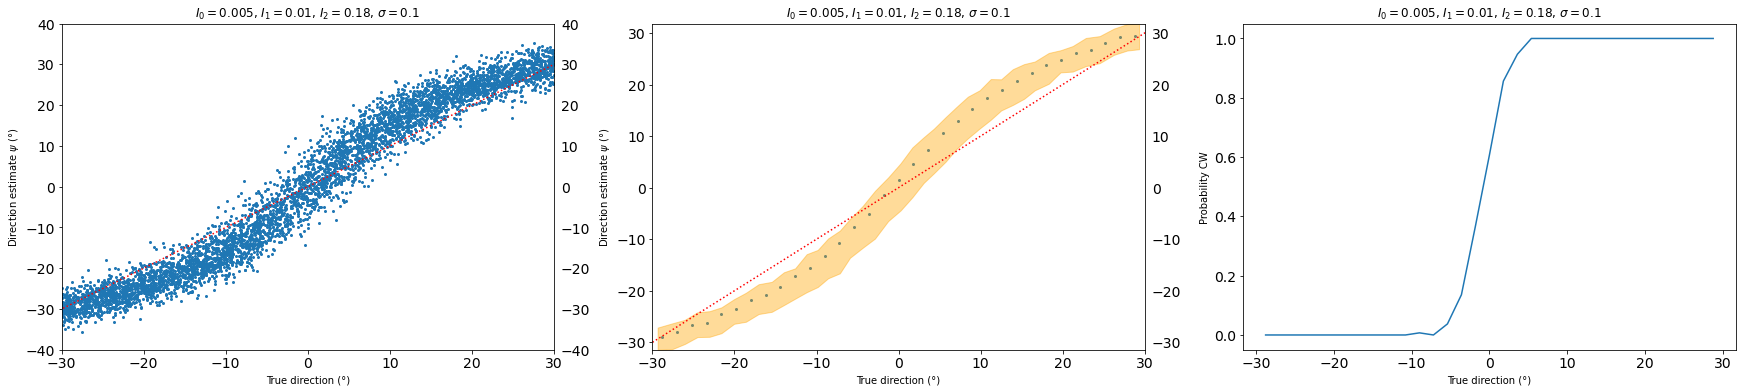

In [811]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 6))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)

x = df.theta.values * 180 / np.pi
y = df.theta_est.values * 180 / np.pi
x1 = np.linspace(-90, 90, 100); y1 = x1

ax1.scatter(x, y, s=4)
ax1.plot(x1, y1, ':r')
ax1.axis([-30, 30, -40, 40])
name = '$I_0=$' + str(exc_drive) + ', $I_1=$'+ str(i1) + ', $I_2=$'+ str(i2) + ', $\sigma=$' + str(sigmaou)
ax1.set_title(name)
ax1.set_xlabel("True direction (\N{DEGREE SIGN})")
ax1.set_ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
ax1.tick_params(labelright=True)

# Estimació vs. average direction (circular mean)
x = df2.theta.values * 180 / np.pi
y = df2.theta_est.values * 180 / np.pi

ax2.scatter(x, y, s=4)
ax2.plot(x1, y1, ':r')

# uncertainty lines (95% confidence)
ax2.fill_between(sx, sy + ss, sy - ss, color='orange', alpha=0.4)
ax2.axis([-30, 30, min(sy - ss), max(sy + ss)])
ax2.set_title(name)
ax2.set_xlabel("True direction (\N{DEGREE SIGN})")
ax2.set_ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
ax2.tick_params(labelright=True)

x = df2.theta.values[np.abs(df2.loc[:,'theta'].values) < 30 * np.pi / 180] * 180 / np.pi
y = df2.prob.values[np.abs(df2.loc[:,'theta'].values) < 30 * np.pi / 180]

ax3.plot(x, y)
ax3.set_title(name)
ax3.set_xlabel("True direction (\N{DEGREE SIGN})")
ax3.set_ylabel("Probability CW")

os.chdir('/Users/miguel/Desktop/fisica_mates/cinque/tfg-ring_network/code/simulations')
if dec_mode == 0:
    plt.savefig('Est_I0='+ str(exc_drive) + '_I1='+ str(i1) + '_I2='+ str(i2) + '_sigma='+ str(sigmaou) + '_tstim=' + str(tmax) + '.jpg')
if dec_mode == 1:
    plt.savefig('Est_I0='+ str(exc_drive) + '_I1='+ str(i1) + '_I2='+ str(i2) + '_sigma='+ str(sigmaou) + '_tstim=' + str(tmax) + '_tbias=' + str(tbias) + '.jpg')
plt.show()

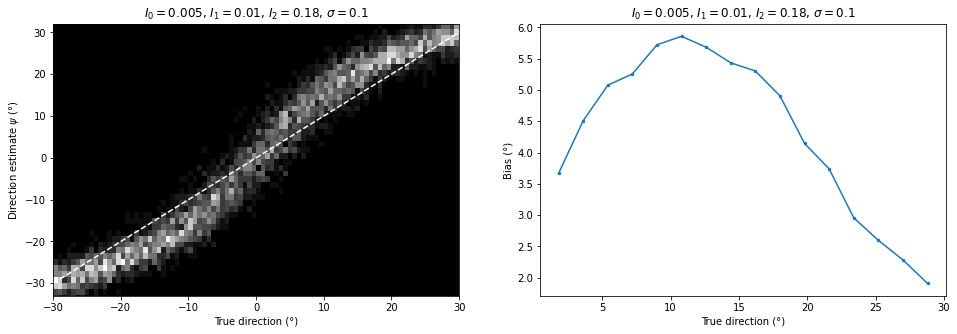

In [812]:
fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(16, 5))

x1 = np.linspace(-60, 60, 100); y1 = x1
ax1.plot(x1, y1, '--', c="white")

ax1.hist2d(df.theta.values * 180 / np.pi, df.theta_est.values * 180 / np.pi, cmap = 'gray', bins=(90, 50), density=True, vmax=0.00375)
name = '$I_0=$' + str(exc_drive) + ', $I_1=$'+ str(i1) + ', $I_2=$'+ str(i2) + ', $\sigma=$' + str(sigmaou)
ax1.set_title(name)
ax1.set_xlabel("True direction (\N{DEGREE SIGN})")
ax1.set_ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
ax1.axis([-30, 30, -33, 32])

#eps = 0.05
#h1 = df.loc[df.theta.between(-np.pi/6, -np.pi/6 + eps, inclusive=True)].theta_est * 180 / np.pi
#h2 = df.loc[df.theta.between(-np.pi/8, -np.pi/8 + eps, inclusive=True)].theta_est * 180 / np.pi
#h3 = df.loc[df.theta.between(-np.pi/12, -np.pi/12 + eps, inclusive=True)].theta_est * 180 / np.pi
#h4 = df.loc[df.theta.between(0, 0 + eps, inclusive=True)].theta_est * 180 / np.pi
#h5 = df.loc[df.theta.between(np.pi/12 - eps, np.pi/12, inclusive=True)].theta_est * 180 / np.pi
#h6 = df.loc[df.theta.between(np.pi/8 - eps, np.pi/8, inclusive=True)].theta_est * 180 / np.pi
#h7 = df.loc[df.theta.between(np.pi/6 - eps, np.pi/6, inclusive=True)].theta_est * 180 / np.pi

#ax2.violinplot([h1, h2, h3, h4, h5, h6, h7], showmeans=True, showextrema=False)
#ax2.set_title(name)
#ax2.set_xlabel("True direction (\N{DEGREE SIGN})")
#ax2.set_ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")

# Estimació vs. average direction (circular mean)
x = df2.theta[df2.theta > 0].values * 180 / np.pi
y = df2.bias[df2.theta > 0].values * 180 / np.pi

ax3.scatter(x[0:33], y[0:33], s=6)
ax3.plot(x[0:33], y[0:33])
std = df2.bias_std[df2.theta > 0].values * 180 / np.pi
#ax3.fill_between(x, y + std, y - std, color='orange', alpha=0.4)
ax3.set_title(name)
ax3.set_xlabel("True direction (\N{DEGREE SIGN})")
ax3.set_ylabel("Bias (\N{DEGREE SIGN})")

os.chdir('/Users/miguel/Desktop/fisica_mates/cinque/tfg-ring_network/code/simulations')
if dec_mode == 0:
    plt.savefig('scatter_Est_I0='+ str(exc_drive) + '_I1='+ str(i1) + '_I2='+ str(i2) + '_sigma='+ str(sigmaou) + '_tstim=' + str(tmax) + '.jpg')
if dec_mode == 1:
    plt.savefig('scatter_Est_I0='+ str(exc_drive) + '_I1='+ str(i1) + '_I2='+ str(i2) + '_sigma='+ str(sigmaou) + '_tstim=' + str(tmax) + '_tbias=' + str(tbias) + '.jpg')
plt.show()
plt.show()

In [813]:
d = df2.bias[df2.theta > 0].values * 180 / np.pi

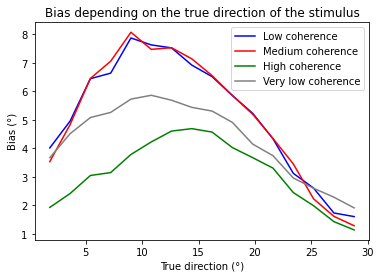

In [816]:
#plt.scatter(x[0:33], a[0:33], s=6, c='blue')
plt.plot(x[0:33], a[0:33], c='blue')
#plt.scatter(x[0:33], b[0:33], s=6, c='red')
plt.plot(x[0:33], b[0:33], c='red')
#plt.scatter(x[0:33], c[0:33], s=6, c='green')
plt.plot(x[0:33], c[0:33], c='green')
#plt.scatter(x[0:33], d[0:33], s=6, c='gray')
plt.plot(x[0:33], d[0:33], c='gray')
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel("Bias (\N{DEGREE SIGN})")
plt.title("Bias depending on the true direction of the stimulus")
plt.legend(['Low coherence','Medium coherence','High coherence','Very low coherence'])
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3750, 200) and arg 2 with shape (5500, 200).

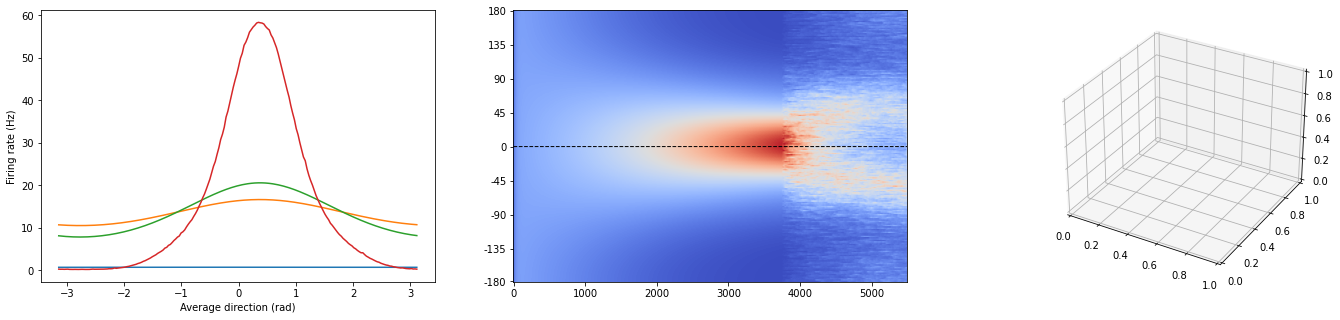

In [517]:
fig = plt.figure(figsize=(24, 5))
fig.tight_layout(pad=3.0)

ax1 = fig.add_subplot(131)
for i in [0, 500, 1000, -1]:
    ax1.plot(theta, r[i, 9])
ax1.set_xlabel('Average direction (rad)')
ax1.set_ylabel('Firing rate (Hz)')

ax2 = fig.add_subplot(132)
x = np.arange(r.shape[0])
y = np.ones(np.concatenate((tpoints, tpoints_bias)).shape) * 100
ax2.imshow(r[:,0,:].T, aspect='auto', cmap=cm.coolwarm)
ax2.plot(x, y, '--', c="black", lw=1)
ax2.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 199]) # choose which x locations to have ticks
ax2.set_yticklabels([180, 135, 90, 45, 0, -45, -90, -135, -180]) # set the labels to display at those ticks

x = theta * 180 / np.pi
y = tpoints
X,Y = np.meshgrid(x,y)
Z = r[:, 0,:]

ax3 = fig.add_subplot(133, projection='3d')
surf1 = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm)

ax3.view_init(20, 240)
ax3.set_xlabel('Average direction (rad)')
ax3.set_ylabel('Time (s)')
ax3.zaxis.set_label_coords(40, -10)
ax3.zaxis.set_rotate_label(False) 
ax3.set_zlabel('Firing rate (Hz)', rotation=90)
ax3.grid(False)

fig.colorbar(surf1, ax=ax3, shrink=0.6, aspect=20)

plt.show()

In [ ]:
y = np.cos(2 * (theta - np.pi/2))
plt.plot(theta, y)

y = (vonmises.pdf(theta - 45 * np.pi/180, kappa=100) + vonmises.pdf(theta + 45 * np.pi/180, kappa=100) -
     vonmises.pdf(theta - 0.1, kappa=10) - vonmises.pdf(theta + 0.1, kappa=100)) / np.max(vonmises.pdf(theta, kappa=100))                                                                                
plt.plot(theta, y)
plt.xlabel("Preferred orientation of neurons (\N{DEGREE SIGN})")
plt.ylabel("")
plt.legend(['Von Mises', 'Double cosinus'])
plt.title('Von Mises spatially modulated input')
print(np.trapz(y, dx = np.diff(theta)[0]))

#y = np.cos(180/60 * (theta - 60 *np.pi/180))
#plt.plot(theta, y)
print(np.trapz(y, dx = np.diff(theta)[0]))

plt.show()

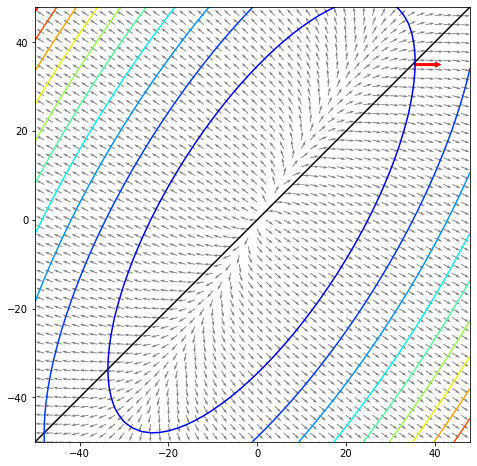

In [510]:
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(figsize=(8, 8))

feature_x = np.arange(-50, 50, 2)
feature_y = np.arange(-50, 50, 2)

x, y = np.meshgrid(feature_x, feature_y)
z = 0.5*(y-x)**2 + 0.5*(1-x)**2
u = 2*x - y - 1
v = y - x

# Normalize all gradients to focus on the direction not the magnitude
norm = np.linalg.norm(np.array((u, v)), axis=0)
u = u / norm
v = v / norm

ax.set_aspect(1)
ax.plot(feature_x, feature_y, c='k')
ax.quiver(x, y, u, v, units='xy', scale=.5, width=0.2, color='gray')
ax.contour(x, y, z, 10, cmap='jet')

arrow = FancyArrowPatch((35, 35), (35+34*0.2, 35+0), arrowstyle='simple',
                        color='r', mutation_scale=10)  
ax.add_patch(arrow)  # NOTE: this gradient is scaled to make it better visible

plt.show()

Text(0.5, 0, '\x08f{time (s)}')

/Users/miguel/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/miguel/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


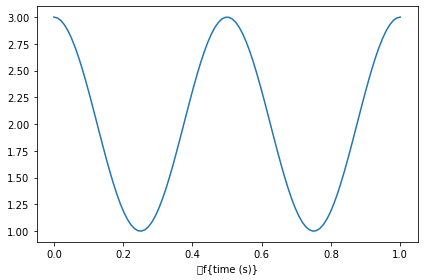

In [21]:
t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel('\bf{time (s)}')

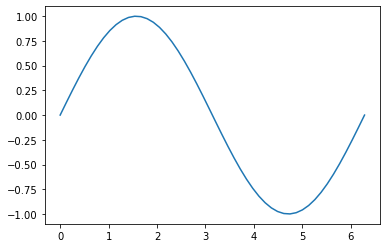

In [38]:
x = np.linspace(0, 360) * np.pi / 180
y = np.cos(x - np.pi / 2)
plt.plot(x, y)
plt.show()